In [1]:
from PIL import Image
import pandas as pd
import pygeostat as gs
import numpy as np

In [2]:
im = Image.open("geomap.emf")

In [3]:
from __future__ import print_function
print(im.format, im.size, im.mode)

x_size = im.size[0]
y_size = im.size[1]

WMF (235, 235) RGB


In [4]:
im_data = list(im.getdata())

In [5]:
xy_tuples = []
for y in reversed(range(y_size)):
    for x in (range(x_size)):
        xy_tuples.append([x,y])
        
for index,pixel in enumerate(xy_tuples):
    pixel.append(im_data[index][0])

In [6]:
df = pd.DataFrame(xy_tuples, columns=['x','y','code'])

In [7]:
#_ = gs.location_plot(data=df, x='x', y='y', z=None, var='code', figsize=(7,7))

In [8]:
df = df.sort_values(by=['y', 'x'])

In [9]:
nx, xmn, xsiz, ny, ymn, ysiz, nz, zmn, zsiz = x_size, 0, 1, y_size, 0, 1, 1, 0, 1

findfont: Font family ['Calibri'] not found. Falling back to Helvetica.
findfont: Font family ['Calibri'] not found. Falling back to Helvetica.


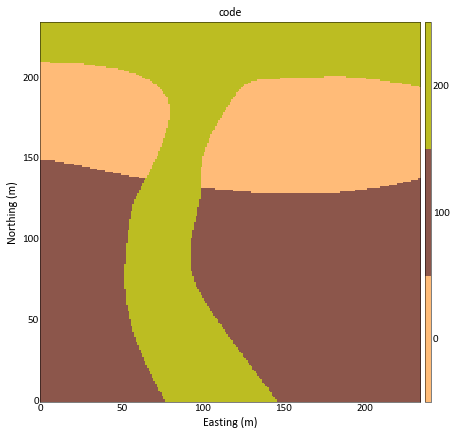

In [24]:
gs.slice_plot(df, griddef=gs.GridDef([nx, xmn, xsiz, ny, ymn, ysiz, nz, zmn, zsiz]), var='code', figsize=(7,7), catdata=True, output_file='exhaustive')

In [11]:
gs.write_gslib(df, 'exhaust.dat')

In [12]:
random_sampling = df.sample(frac=0.003, replace=True)

In [13]:
regular_sampling = pd.DataFrame(columns=['x','y','code'])

In [14]:
x_int = 25
y_int = 25

row_list = []

for x in range(0, x_size, x_int):
    for y in range(0, y_size, y_int):
        row = df.loc[(df['x'] == x) & (df['y'] == y)]

        regular_sampling = regular_sampling.append(row, ignore_index=True)

In [15]:
random_sampling.head()

,x,y,code
29318,178,110,100
29771,161,108,100
7755,0,201,0
13064,139,179,0
49350,0,24,100


In [16]:
regular_sampling.head()

,x,y,code
0,0,0,100
1,0,25,100
2,0,50,100
3,0,75,100
4,0,100,100


In [17]:
full = pd.concat([random_sampling, regular_sampling])

In [18]:
f1 = full['code'] == 0
f2 = full['code'] == 100
f3 = full['code'] == 200
f = f1 | f2 | f3

In [19]:
full = full[f]

In [20]:
full.to_csv('dataset.csv', index=False)

In [21]:
data = gs.DataFile(flname='dataset.csv', x='x', y='y', fltype='csv')

In [22]:
len(data)

266

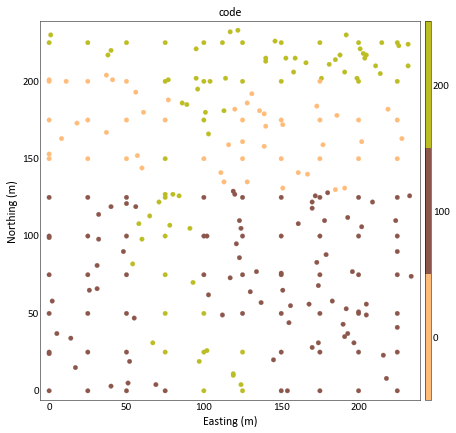

In [25]:
gs.location_plot(data=data, x='x', y='y', z=None, figsize=(7,7), output_file='sampled')